# CS-VQE for Solving Electronic Structure

The second-quantised molecular Hailtonian takes the form

\begin{equation}
H = \sum_{pq} h_{pq} \hat{a}^*_p \hat{a}_q + \frac{1}{2} \sum_{pqrs} h_{pqrs} \hat{a}^*_p \hat{a}^*_q \hat{a}_r \hat{a}_s
\end{equation}

where $\hat{a}$ is the Fermionic annihiliation operator, with its adjoint $\hat{a}^*$ the creation operator. We may map this Hamiltonian onto qubits via some transformation such as Jordan-Wigner, where

\begin{equation}
\hat{a}_p \mapsto \frac{1}{2} (X_p + i Y_p) \otimes \bigotimes_{q<p} Z_q.
\end{equation}
Let us see what this Hamiltonian looks like in practice:

In [1]:
from symmer.chemistry import MoleculeBuilder

atoms  = ['Be']
coords = [(0,0,0)]
charge = 0
spin   = 0
basis  = 'sto-3g'

molecule = MoleculeBuilder(
    geometry=list(zip(atoms, coords)), 
    charge=charge, 
    basis=basis, 
    spin=spin, 
    run_fci=True, 
    print_info=True
)

Molecule geometry:
Be	0	0	0

CISD converged?  True
FCI converged?  True
FCI converged?  True

HF energy:   -14.351880476202023
MP2 energy:  -14.376238850841515
CCSD energy: -14.403650751752787
CISD energy: -14.403645784721308
FCI energy:  -14.403655108067682


Number of qubits: 10


In [2]:
molecule.data_dictionary()

{'qubit_encoding': 'jordan_wigner',
 'unit': 'angstrom',
 'geometry': '1\n \nBe\t0\t0\t0',
 'basis': 'sto-3g',
 'charge': 0,
 'spin': 0,
 'hf_array': [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 'hf_method': 'pyscf.scf.hf.RHF',
 'n_particles': {'total': 4, 'alpha': 2, 'beta': 2},
 'n_qubits': 10,
 'convergence_threshold': 1e-06,
 'point_group': {'groupname': 'C1', 'topgroup': 'C1'},
 'calculated_properties': {'HF': {'energy': -14.351880476202023,
   'converged': True},
  'MP2': {'energy': -14.376238850841515, 'converged': True},
  'CCSD': {'energy': -14.403650751752787, 'converged': True},
  'CISD': {'energy': -14.403645784721304, 'converged': True},
  'FCI': {'energy': -14.403655108067682, 'converged': True}},
 'auxiliary_operators': {'number_operator': {'IIIIIIIIII': (5.0, 0.0),
   'IIIIIIIIIZ': (-0.5, 0.0),
   'IIIIIIIIZI': (-0.5, 0.0),
   'IIIIIIIZII': (-0.5, 0.0),
   'IIIIIIZIII': (-0.5, 0.0),
   'IIIIIZIIII': (-0.5, 0.0),
   'IIIIZIIIII': (-0.5, 0.0),
   'IIIZIIIIII': (-0.5, 0.0),
   'IIZIII

The second-quantised Hamiltonian for this molecular system:

In [3]:
print(molecule.H)

-7.8575006535368574 [0^ 0] +
1.1376669191197275 [0^ 0^ 0 0] +
-0.1266650547067105 [0^ 0^ 0 2] +
-0.12666505470671052 [0^ 0^ 2 0] +
0.02214895386816603 [0^ 0^ 2 2] +
0.007799539287510122 [0^ 0^ 4 4] +
0.007799539287510122 [0^ 0^ 6 6] +
0.007799539287510122 [0^ 0^ 8 8] +
1.1376669191197275 [0^ 1^ 1 0] +
-0.1266650547067105 [0^ 1^ 1 2] +
-0.12666505470671052 [0^ 1^ 3 0] +
0.02214895386816603 [0^ 1^ 3 2] +
0.007799539287510122 [0^ 1^ 5 4] +
0.007799539287510122 [0^ 1^ 7 6] +
0.007799539287510122 [0^ 1^ 9 8] +
0.26757386046668147 [0^ 2] +
-0.12666505470671052 [0^ 2^ 0 0] +
0.02214895386816603 [0^ 2^ 0 2] +
0.2856181541250914 [0^ 2^ 2 0] +
-0.007121875526630251 [0^ 2^ 2 2] +
0.010281285614826111 [0^ 2^ 4 4] +
0.010281285614826111 [0^ 2^ 6 6] +
0.010281285614826111 [0^ 2^ 8 8] +
-0.12666505470671052 [0^ 3^ 1 0] +
0.02214895386816603 [0^ 3^ 1 2] +
0.2856181541250914 [0^ 3^ 3 0] +
-0.007121875526630251 [0^ 3^ 3 2] +
0.010281285614826111 [0^ 3^ 5 4] +
0.010281285614826111 [0^ 3^ 7 6] +
0.0102812

... and after a mapping onto qubits, we obtain the Hamiltonian

In [4]:
H = molecule.H_q
print(H)

-9.009+0.000j IIIIIIIIII +
 2.243+0.000j ZIIIIIIIII +
 0.038+0.000j YZYIIIIIII +
 0.038+0.000j XZXIIIIIII +
 2.243+0.000j IZIIIIIIII +
 0.038+0.000j IYZYIIIIII +
 0.038+0.000j IXZXIIIIII +
-0.047+0.000j IIZIIIIIII +
-0.047+0.000j IIIZIIIIII +
-0.148+0.000j IIIIZIIIII +
-0.148+0.000j IIIIIZIIII +
-0.148+0.000j IIIIIIZIII +
-0.148+0.000j IIIIIIIZII +
-0.148+0.000j IIIIIIIIZI +
-0.148+0.000j IIIIIIIIIZ +
 0.569+0.000j ZZIIIIIIII +
 0.063+0.000j YIYIIIIIII +
 0.063+0.000j XIXIIIIIII +
 0.063+0.000j ZYZYIIIIII +
 0.063+0.000j ZXZXIIIIII +
 0.011+0.000j YXXYIIIIII +
-0.011+0.000j YYXXIIIIII +
-0.011+0.000j XXYYIIIIII +
 0.011+0.000j XYYXIIIIII +
 0.004+0.000j YXIIXYIIII +
-0.004+0.000j YYIIXXIIII +
-0.004+0.000j XXIIYYIIII +
 0.004+0.000j XYIIYXIIII +
 0.004+0.000j YXIIIIXYII +
-0.004+0.000j YYIIIIXXII +
-0.004+0.000j XXIIIIYYII +
 0.004+0.000j XYIIIIYXII +
 0.004+0.000j YXIIIIIIXY +
-0.004+0.000j YYIIIIIIXX +
-0.004+0.000j XXIIIIIIYY +
 0.004+0.000j XYIIIIIIYX +
 0.132+0.000j ZIZIIIIIII +
 

Note that the ground state energy of this Hamiltonian matches the full-configuration interaction (FCI) energy above

In [5]:
from symmer.utils import exact_gs_energy
from symmer.symplectic import QuantumState

gs_nrg, gs_psi = exact_gs_energy(molecule.H_q.to_sparse_matrix)

print(f'Ground state energy = {gs_nrg}, with FCI error {abs(gs_nrg - molecule.fci_energy)}.\n')
print('The ground state is:\n'); print(gs_psi)

Ground state energy = -14.403655108067936, with FCI error 2.540190280342358e-13.

The ground state is:

 0.000+0.000j |0000001111> +
 0.000+0.000j |0000110011> +
 0.000+0.000j |0000111100> +
-0.001-0.001j |0011000011> +
-0.001-0.001j |0011001100> +
-0.001-0.001j |0011110000> +
-0.002-0.002j |0110000011> +
-0.002-0.002j |0110001100> +
-0.002-0.002j |0110110000> +
 0.002+0.002j |1001000011> +
 0.002+0.002j |1001001100> +
 0.002+0.002j |1001110000> +
-0.133-0.130j |1100000011> +
-0.133-0.130j |1100001100> +
-0.133-0.130j |1100110000> +
-0.000+0.000j |1101000001> +
 0.000+0.000j |1101000010> +
-0.000+0.000j |1101000100> +
 0.000+0.000j |1101001000> +
 0.000+0.000j |1101010000> +
-0.000+0.000j |1101010001> +
 0.000-0.000j |1101100000> +
-0.000+0.000j |1110000001> +
-0.000-0.000j |1110000010> +
 0.000+0.000j |1110000100> +
 0.000+0.000j |1110001000> +
-0.000-0.000j |1110010000> +
-0.000+0.000j |1110100000> +
 0.678+0.661j |1111000000> +
 0.000-0.000j |1111000001> +
-0.000-0.000j |1111001000>

# Taper the Hamiltonian first

Before we apply CS-VQE, one might as well perform qubit tapering since it does not introduce any systematic error

In [6]:
from symmer.projection import QubitTapering

QT = QubitTapering(H)
print(f'Qubit tapering permits a reduction of {H.n_qubits} -> {H.n_qubits-QT.n_taper} qubits.\n')
print('The following symmetry generators were identified:\n')
print(QT.symmetry_generators); print()
print('which we may rotate onto the single-qubit Pauli operators\n') 
print(QT.symmetry_generators.rotate_onto_single_qubit_paulis()); print()
print('via a sequence of Clifford operations R_k = e^{i pi/4 P_k} where:\n')
for index, (P_k, angle) in enumerate(QT.symmetry_generators.stabilizer_rotations):
    P_k.sigfig=0
    print(f'P_{index} = {P_k}')

Qubit tapering permits a reduction of 10 -> 5 qubits.

The following symmetry generators were identified:

 1 IIIIIIIIZZ 
 1 IIIIIIZZII 
 1 IIIIZZIIII 
 1 IZIZIZIZIZ 
 1 ZIZIIZIZIZ

which we may rotate onto the single-qubit Pauli operators

-1 IIIIIIIIXI 
-1 IIIIIIXIII 
-1 IIIIXIIIII 
-1 IXIIIIIIII 
-1 XIIIIIIIII

via a sequence of Clifford operations R_k = e^{i pi/4 P_k} where:

P_0 =  1+0j IIIIIIIIYZ
P_1 =  1+0j IIIIIIYZII
P_2 =  1+0j IIIIYZIIII
P_3 =  1+0j IYIZIZIZIZ
P_4 =  1+0j YIZIIZIZIZ


In [7]:
H_taper = QT.taper_it(ref_state=molecule.hf_array) 
UCC_taper = QT.taper_it(aux_operator=molecule.UCC_q)
# note the reference state to place us in the correct symmetry sector!

gs_nrg_tap, gs_psi_tap = exact_gs_energy(H_taper.to_sparse_matrix)

print(f'The ground state energy of the Hamiltonian is {gs_nrg}')
print(f'and for the {H_taper.n_qubits}-qubit tapered Hamiltonian it is {gs_nrg_tap};')
print(f'the energy error is {abs(gs_nrg - gs_nrg_tap)}.\n')
print('The tapered ground state is:\n')
print(gs_psi_tap)

The ground state energy of the Hamiltonian is -14.403655108067936
and for the 5-qubit tapered Hamiltonian it is -14.40365510806768;
the energy error is 2.5579538487363607e-13.

The tapered ground state is:

-0.186+0.000j |00001> +
-0.186+0.000j |00010> +
-0.001+0.000j |00011> +
-0.186+0.000j |00100> +
-0.001+0.000j |00101> +
-0.001+0.000j |00110> +
-0.003+0.000j |01001> +
-0.003+0.000j |01010> +
-0.003+0.000j |01100> +
 0.003+0.000j |10001> +
 0.003+0.000j |10010> +
 0.003+0.000j |10100> +
-0.946+0.000j |11000> +
-0.001+0.000j |11001> +
-0.001+0.000j |11010> +
-0.001+0.000j |11100>


# Now we build the CS-VQE model

This involves partitioning $H$ into _noncontextual_ and _contextual_ componenents satisfying $H = H_\mathrm{noncon} + H_\mathrm{context}$.

In [8]:
from symmer.projection import ContextualSubspace

cs_vqe = ContextualSubspace(H_taper, noncontextual_strategy='SingleSweep_magnitude')

Noncontextual Hamiltonians have a very specific form, namely their terms $\mathcal{T}$ may be decomposed as
\begin{equation}
    \mathcal{T} = \mathcal{S} \cup \mathcal{C}_1 \cup \dots \cup \mathcal{C}_M 
\end{equation}
where $\mathcal{S}$ contains the terms that commute globally (i.e. the noncontextual symmetries) and a collection of cliques with respect to commutation.

In [9]:
cs_vqe.noncontextual_operator.decomposed

{'symmetry': -8.672+0.000j IIIII +
 -0.297+0.000j IIIIZ +
 -0.297+0.000j IIIZI +
  0.389+0.000j IIIZZ +
 -0.297+0.000j IIZII +
  0.389+0.000j IIZIZ +
  0.389+0.000j IIZZI +
  0.263+0.000j IIZZZ +
 -0.047+0.000j IZIII +
  0.183+0.000j IZIIZ +
  0.183+0.000j IZIZI +
  0.281+0.000j IZIZZ +
  0.183+0.000j IZZII +
  0.281+0.000j IZZIZ +
  0.281+0.000j IZZZI +
  2.243-0.000j IZZZZ,
 'clique_0': -0.060+0.000j XIIII +
  0.060+0.000j XIZZZ +
  0.038-0.000j XZIII +
  0.010+0.000j XZIIZ +
  0.010+0.000j XZIZI +
 -0.010+0.000j XZIZZ +
  0.010+0.000j XZZII +
 -0.010+0.000j XZZIZ +
 -0.010+0.000j XZZZI +
 -0.038+0.000j XZZZZ,
 'clique_1': -0.047+0.000j ZIIII +
  0.183+0.000j ZIIIZ +
  0.183+0.000j ZIIZI +
  0.281+0.000j ZIIZZ +
  0.183+0.000j ZIZII +
  0.281+0.000j ZIZIZ +
  0.281+0.000j ZIZZI +
  2.243-0.000j ZIZZZ +
  0.670+0.000j ZZIII +
  0.286+0.000j ZZZZZ}

Representing the Hamiltonian as a graph with edges denoting commutation between Pauli operators, this structure corresponds with a partition into complete subgraphs:

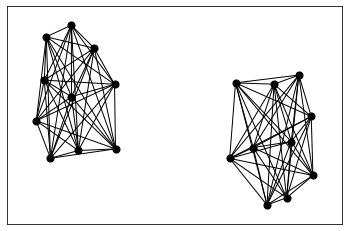

In [10]:
from symmer.symplectic import ObservableGraph, PauliwordOp
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np

adjmat = cs_vqe.noncontextual_operator.adjacency_matrix.copy()
mask_nonsymmetries = ~np.all(adjmat, axis=1)
adjmat = adjmat[mask_nonsymmetries,:][:,mask_nonsymmetries]
np.fill_diagonal(adjmat, False)
graph = nx.from_numpy_matrix(adjmat)

plt.figure()
pos = nx.spring_layout(graph, k=1)
nx.draw_networkx_nodes(graph,pos,node_color='black', node_size=50)
nx.draw_networkx_edges(graph, pos,width=1)
plt.show()

Identifying a generating set $\mathcal{G}$ for the symmetry terms $\mathcal{S}$ and constructing the clique operator $A(\vec{r}) = \sum_{i=1}^M r_i C_i$ for clique representatives $C_i \in \mathcal{C}_i$ and coefficients $\vec{r} \in \mathbb{R}^M$ satisfying $|\vec{r}|=1$ allows us to rewrite

\begin{equation}
    H_\mathrm{noncon} = \sum_{P \in \overline{\mathcal{G}}} \bigg(h_{P}^\prime + \sum_{i=1}^M h_{P,i} C_i \bigg) P,
\end{equation}

and yields a classical objective function over parameters $\vec{\nu} \in \{\pm 1\}^{|\mathcal{G}|}$ and $\vec{r} \in \mathbb{R}^M$ for the noncontetual energy expectation value:

\begin{equation}\label{classical_objective}
\begin{aligned}
    \eta(\vec{\nu}, \vec{r}) 
    :={} & {\langle H_\mathrm{noncon} \rangle_{(\vec{\nu}, \vec{r})}} \\
    ={} & \sum_{P \in \overline{\mathcal{G}}} \bigg(h_{P}^\prime + \sum_{i=1}^M h_{P,i} \langle{C_i}\rangle_{(\vec{\nu}, \vec{r})} \bigg) \langle{P}\rangle_{(\vec{\nu}, \vec{r})} \\
    ={} & \sum_{P \in \overline{\mathcal{G}}} \bigg(h_{P}^\prime + \sum_{i=1}^M h_{P,i} r_i \bigg) \prod_{G \in \mathcal{G}_{P}} \nu_{f(G)}.
\end{aligned}
\end{equation}

In [11]:
print('The symmetry generators G are:\n')
print(cs_vqe.noncontextual_operator.symmetry_generators); print()
print('The clique operator A(r) is:\n')
print(cs_vqe.noncontextual_operator.clique_operator); print()
print(f'The optimal paramters are '+ 
      f'nu={cs_vqe.noncontextual_operator.symmetry_generators.coeff_vec}, r={cs_vqe.noncontextual_operator.clique_operator.coeff_vec},')
print(f'which yields a noncontextual energy of n(nu,r) = {cs_vqe.noncontextual_operator.energy}')

The symmetry generators G are:

 1 IIIIZ 
 1 IIIZI 
 1 IIZII 
-1 IZIII

The clique operator A(r) is:

 0.000 XIIII +
-1.000 ZIIII

The optimal paramters are nu=[ 1  1  1 -1], r=[ 1.45865824e-08 -1.00000000e+00],
which yields a noncontextual energy of n(nu,r) = -14.351880476202028


# Quantum corrections

We have obtained a classical estimate to the ground state energy from the noncontextual Hamiltonian - the power of CS-VQE is in how it derives quantum corrections from a VQE simulation of the contextual Hamiltonian. To ensure the corrections are valid, we constrain the contextual problem by the solution to the noncontextual one. This is achieved via stabilizer subspace projections - similar in vain to tapering, except the imposed symmetries are those of the noncontextual Hamiltonian. This results in a loss of information, since symmetry-breaking terms vanish under such a projection. 

We choose a set of stabilizers $\mathcal{F}$ we would like to fix in the contextual subspace; identifying a unitary operation $U_\mathcal{F}$ mapping $\mathcal{F}$ to single-qubit Pauli operators we may obtain a reduced $(N-|\mathcal{F}|)$-qubit Hamiltonian

\begin{equation}
    \tilde{H}= \pi_{U_{\mathcal{F}}} (H_\mathrm{context})
\end{equation}

with the projection $\pi(\cdot)$ defined in [this](https://arxiv.org/pdf/2204.02150.pdf) paper.

In [13]:
cs_vqe.update_stabilizers(n_qubits = 3, strategy='aux_preserving', aux_operator=UCC_taper)
# the user may specify stabilizers manually also:
# cs_vqe.manual_stabilizers(['ZIZZZ', 'ZZIII'])

H_cs = cs_vqe.project_onto_subspace()
print(f'We may project into the contextual subspace stabilized by '+
      f'{list(cs_vqe.stabilizers.to_dictionary.keys())} via a sequence of rotations:\n')

if cs_vqe.perform_unitary_partitioning:
    print(f'Note the clique operator')
    print(cs_vqe.noncontextual_operator.clique_operator) 
    print('is enforced for this set of stabilizers.')
#for index, (P_k, angle) in enumerate(
#    cs_vqe.unitary_partitioning_rotations+cs_vqe.stabilizers.stabilizer_rotations
#    ):
#    P_k.sigfig=0
#    print(f'P_{index} = {P_k}')
    
print(f'\nand tracing over qubit positions {cs_vqe.stab_qubit_indices} yields the {H_cs.n_qubits}-qubit Hamiltonian:\n')
print(H_cs)

We may project into the contextual subspace stabilized by ['IZZZZ', 'ZIZZZ'] via a sequence of rotations:

Note the clique operator
 0.000 XIIII +
-1.000 ZIIII
is enforced for this set of stabilizers.

and tracing over qubit positions [1 0] yields the 3-qubit Hamiltonian:

-12.489+0.000j III +
-0.858+0.000j IIZ +
-0.858+0.000j IZI +
 0.023+0.000j IZZ +
-0.858+0.000j ZII +
 0.023+0.000j ZIZ +
 0.023+0.000j ZZI +
 0.642+0.000j ZZZ +
-0.043+0.000j IIX +
-0.043+0.000j ZZX +
-0.043+0.000j IXI +
-0.043+0.000j ZXZ +
 0.012+0.000j IXX +
 0.012+0.000j IYY +
-0.043+0.000j XII +
-0.043+0.000j XZZ +
 0.012+0.000j XIX +
 0.012+0.000j YIY +
 0.012+0.000j XXI +
 0.012+0.000j YYI


In [14]:
cs_vqe.stabilizers.stabilizer_rotations

[( 1.000+0.000j YIZZZ, None),
 ( 1.000+0.000j IYZZZ, None),
 ( 1.000+0.000j IYIII, None),
 ( 1.000+0.000j YIIII, None)]

In [15]:
cs_vqe.unitary_partitioning_rotations

 0.000+0.000j IIIII +
 0.000+1.000j YIIII

Performing a VQE simulation over this Hamiltonian yields the quantum-corrected energy

In [16]:
from symmer.symplectic import ObservableOp, AnsatzOp

UCC_cs = cs_vqe.project_onto_subspace(UCC_taper)
obs_cs = ObservableOp(H_cs.symp_matrix, H_cs.coeff_vec)
anz_cs = AnsatzOp(UCC_cs.symp_matrix, np.random.random(UCC_cs.n_terms))
ref_cs = molecule.hf_array[QT.free_qubit_indices][cs_vqe.free_qubit_indices]

vqe_result, interim_data = obs_cs.VQE(
    ansatz_op=anz_cs, 
    ref_state=ref_cs,
    optimizer='BFGS',
    maxiter=20
)
print(f'Converged VQE energy = {vqe_result.fun} with FCI error {abs(vqe_result.fun-molecule.fci_energy)}')

Converged VQE energy = -14.40332860225806 with FCI error 0.00032650580962112485


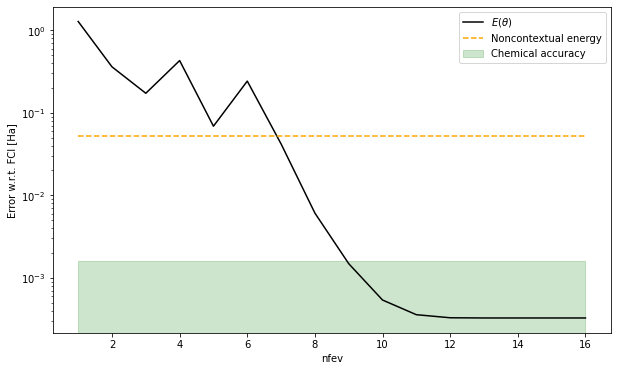

In [17]:
fig, axis = plt.subplots(figsize=(10,6))

X,Y = zip(*interim_data['values'])
axis.plot(X, abs(np.array(Y)-molecule.fci_energy), color='black', label='$E(\\theta)$')
axis.hlines(abs(cs_vqe.noncontextual_operator.energy-molecule.fci_energy), 1, X[-1], color='orange', ls='--', label='Noncontextual energy')
axis.fill_between(X, 0, 0.0016, color='green', alpha=0.2, label='Chemical accuracy')
axis.set_yscale('log')
axis.set_ylabel('Error w.r.t. FCI [Ha]')
axis.set_xlabel('nfev')
axis.legend()
plt.show()